# PART 2!
# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption


This notebook is accompanied by a Youtube tutorial.

[WATCH THE FIRST VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/tmp/ipykernel_1074/684154541.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../data/raw/PJMW_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

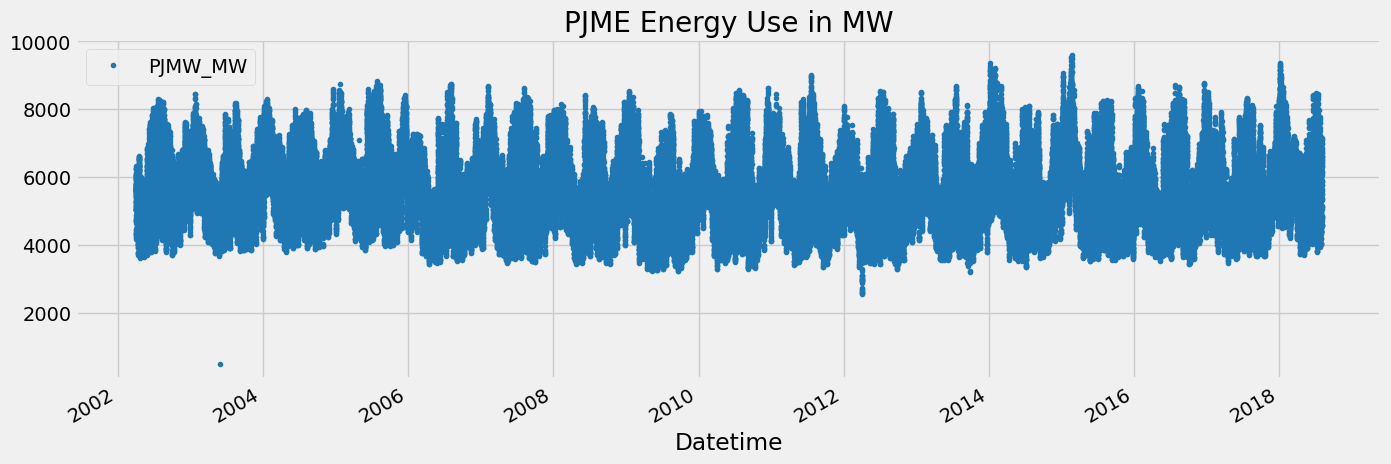

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

In [4]:
df[df['PJMW_MW']<2000]

,PJMW_MW
Datetime,
2003-05-29,487.0


In [5]:
df.loc["2003-05-29"]

,PJMW_MW
Datetime,
2003-05-29 01:00:00,4560.0
2003-05-29 02:00:00,4424.0
2003-05-29 03:00:00,4351.0
2003-05-29 04:00:00,4337.0
2003-05-29 05:00:00,4393.0
2003-05-29 06:00:00,4649.0
2003-05-29 07:00:00,5108.0
2003-05-29 08:00:00,5419.0
2003-05-29 09:00:00,5562.0


In [6]:
df.loc["2003-05-28"]

,PJMW_MW
Datetime,
2003-05-28 01:00:00,4500.0
2003-05-28 02:00:00,4341.0
2003-05-28 03:00:00,4227.0
2003-05-28 04:00:00,4278.0
2003-05-28 05:00:00,4342.0
2003-05-28 06:00:00,4618.0
2003-05-28 07:00:00,5149.0
2003-05-28 08:00:00,5478.0
2003-05-28 09:00:00,5559.0


Seems like the value of 487.0 is just a typo and it has to be 4870.0

In [7]:
df['PJMW_MW'] = df['PJMW_MW'].replace(487, 4870)

<Axes: ylabel='Frequency'>

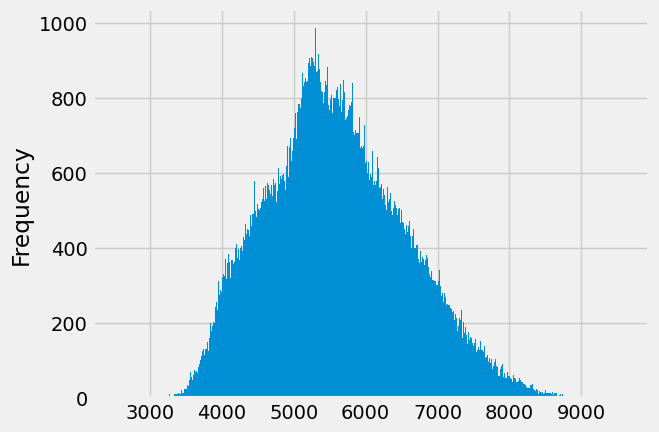

In [8]:
df['PJMW_MW'].plot(kind='hist', bins=500)

In [23]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.5 kB/s eta 0:00:0000:0100:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 52.8 kB/s eta 0:00:00a 0:00:01


/tmp/ipykernel_37080/314628662.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 143206.
  stat, p = shapiro(df['PJMW_MW'])


Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=2940.760, p=0.000
Sample does not look Gaussian (reject H0)


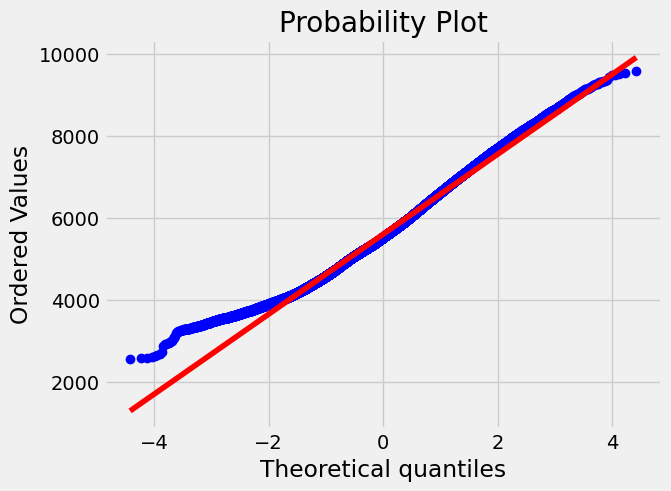

In [32]:
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import normaltest
stats.probplot(df['PJMW_MW'], dist="norm", plot=plt)
stat, p = shapiro(df['PJMW_MW'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

stat, p = normaltest(df['PJMW_MW'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

data distribution is not normal, then it is better to not use linear regression.

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

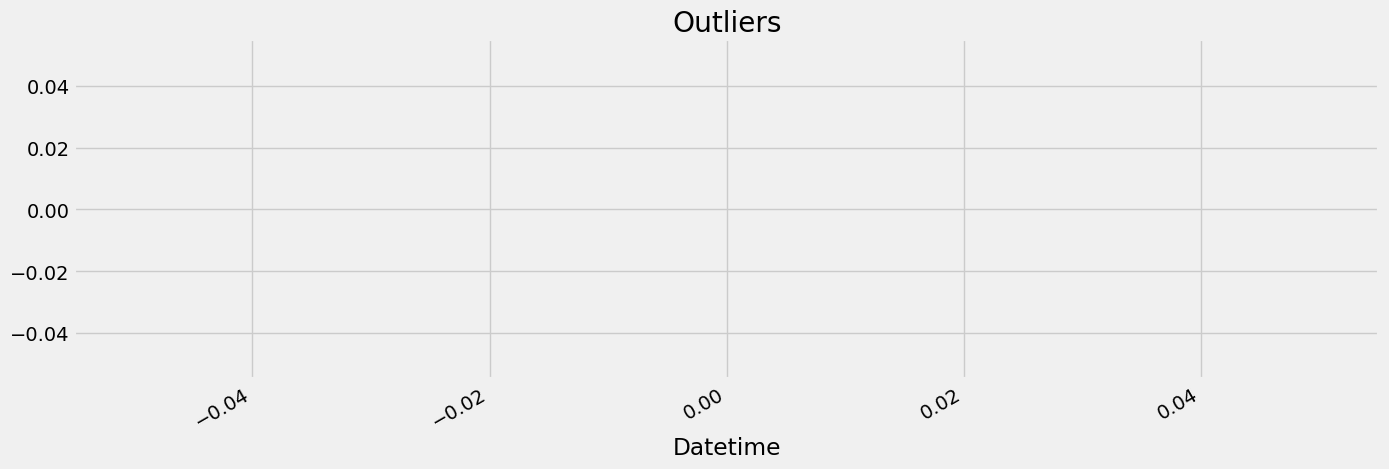

In [33]:
df.query('PJMW_MW < 2_000')['PJMW_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

# Reviewing: Train / Test Split

# 1. Time Series Cross Validation

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

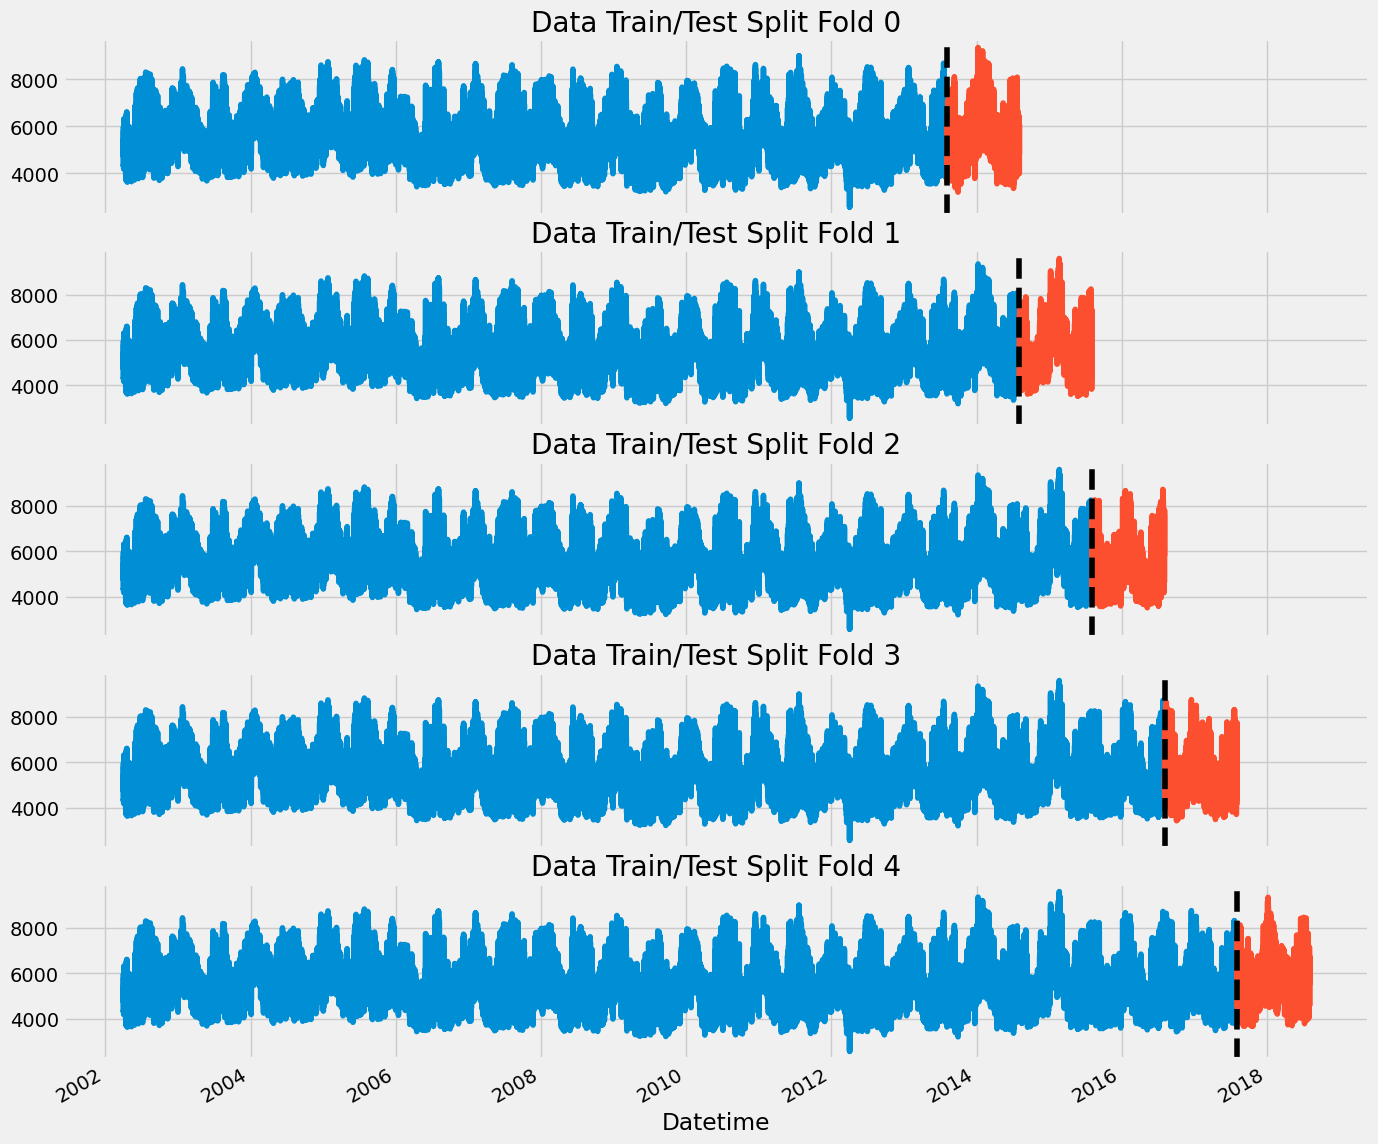

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJMW_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJMW_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [12]:
def add_lags(df):
    target_map = df['PJMW_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [13]:
df = add_lags(df)

## Train Using Cross Validation

In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJMW_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=100,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5625.68705	validation_1-rmse:5689.19519
[99]	validation_0-rmse:2155.30552	validation_1-rmse:2305.88786
[0]	validation_0-rmse:5630.69354	validation_1-rmse:5764.73865
[99]	validation_0-rmse:2158.43858	validation_1-rmse:2365.27304
[0]	validation_0-rmse:5640.50639	validation_1-rmse:5470.46821
[99]	validation_0-rmse:2163.67540	validation_1-rmse:2017.98062
[0]	validation_0-rmse:5628.85080	validation_1-rmse:5556.22219
[99]	validation_0-rmse:2160.25558	validation_1-rmse:2164.58645
[0]	validation_0-rmse:5624.13164	validation_1-rmse:5731.03400
[99]	validation_0-rmse:2160.01190	validation_1-rmse:2322.19953


In [16]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2235.1855
Fold scores:[2305.8878572327985, 2365.273035825719, 2017.9806184005097, 2164.5864492533606, 2322.1995271513447]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [17]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJMW_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:5630.73124
[100]	validation_0-rmse:2143.42244
[200]	validation_0-rmse:960.11986
[300]	validation_0-rmse:638.08256
[400]	validation_0-rmse:566.89133
[499]	validation_0-rmse:547.14279


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [19]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [20]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [21]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

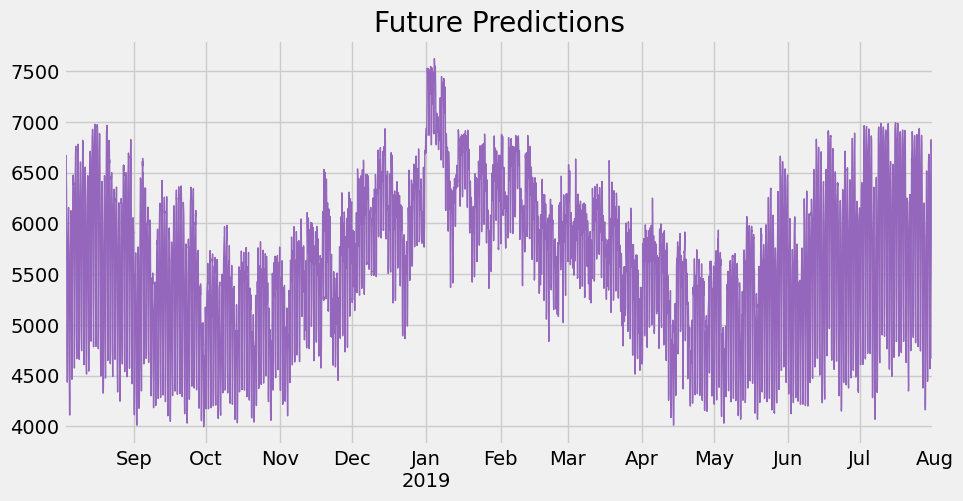

In [22]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

# The End